In [180]:
import numpy as np
import taskGLMPipeline_v2 as tgp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from importlib import reload
tgp = reload(tgp)
import scipy.stats as stats
import pandas as pd
import statsmodels.sandbox.stats.multicomp as mc
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

In [4]:
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030',
            '031','032','033','034','035','037','038','039','040','041','042','043',
            '045','046','047','048','049','050','053','055','056','057','058','062',
            '063','066','067','068','069','070','072','074','075','076','077','081',
            '085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114',
            '115','117','119','120','121','122','123','124','125','126','127','128',
            '129','130','131','132','134','135','136','137','138','139','140','141']

# Load sample subject and plot task regression matrix

In [115]:
subj = '013'
X = tgp.loadTaskTiming(subj,'ALL')
designmat = X['taskDesignMat'] # remove the interaction terms
designmat = np.hstack((designmat[:,:28],designmat[:,-4:]))
stimCond = np.asarray(X['stimCond'])
stimCond = np.hstack((stimCond[:28],stimCond[-4:]))


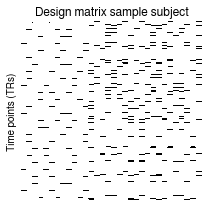

In [189]:
plt.figure(figsize=(3,3))
sns.heatmap(designmat,cmap='binary',cbar=False)
# plt.yticks(np.arange(0,designmat.shape[0],1000),np.arange(0,designmat.shape[0],1000))
plt.yticks([])
# plt.xlabel('Regressors',fontsize=10)
# plt.xticks(np.arange(0,32,4),np.arange(0,32,4),rotation=0)
plt.xticks([])
# plt.yticks(np.arange(0,designmat.shape[1],designmat.shape[1]),np.arange(0,designmat.shape[0],1000)])
plt.ylabel('Time points (TRs)',fontsize=10)
plt.title('Design matrix sample subject',fontsize=12)
plt.tight_layout()
plt.savefig('designMatrix_013.png',dpi=300)

# Run group-level statistics measuring the average cosine similarity of each pair of regressors

In [50]:
unitmats_all = []
for subj in subjNums:
    X = tgp.loadTaskTiming(subj,'ALL')
    designmat = X['taskDesignMat'] # remove the interaction terms
    designmat = np.hstack((designmat[:,:28],designmat[:,-4:]))
    stimCond = np.asarray(X['stimCond'])
    stimCond = np.hstack((stimCond[:28],stimCond[-4:]))
    designmat = designmat - np.mean(designmat,axis=0)
    unitmat = np.divide(designmat,np.linalg.norm(designmat,axis=0))
    unitmats_all.append(unitmat)

#### Average cosine design matrices across subjects

In [51]:
corrmat = []
for unitmat in unitmats_all:
#     unitmat = unitmat - np.mean(unitmat,axis=0)
    tmp = np.dot(unitmat.T,unitmat)
    #tmp = np.corrcoef(unitmat.T)
    corrmat.append(tmp)
    


#### Create dataframes 

In [62]:
rule_cond = ['RuleLogic_BOTH', 'RuleLogic_NOTBOTH', 'RuleLogic_EITHER',
       'RuleLogic_NEITHER', 'RuleSensory_RED', 'RuleSensory_VERTICAL',
       'RuleSensory_HIGH', 'RuleSensory_CONSTANT', 'RuleMotor_LMID',
       'RuleMotor_LIND', 'RuleMotor_RMID', 'RuleMotor_RIND']
resp_cond = ['Response_LMID', 'Response_LIND', 'Response_RMID', 'Response_RIND']

df = {}
df['Subject'] = []
df['Cosine'] = []
df['Response'] = []
df['Stimulus'] = []

scount = 0 
for subj in subjNums:
    stim_ind = 0
    for stim_ind in range(12,28):
        stim = stimCond[stim_ind]
        for resp_ind in range(28,32):
            resp = stimCond[resp_ind]
            df['Subject'].append(scount)
            df['Response'].append(resp)
            df['Stimulus'].append(stim)
            df['Cosine'].append(corrmat[scount][stim_ind,resp_ind])
    scount += 1

df = pd.DataFrame(df)

#### Visualize Cosine similarity of rules x stimuli x motor responses

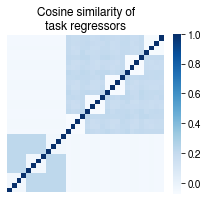

In [182]:

groupavg = np.mean(corrmat,axis=0)
t, p = stats.ttest_1samp(corrmat,0,axis=0)
triu_ind = np.triu_indices(groupavg.shape[0],k=1)
ntests = len(p[triu_ind])
q = p*ntests
sig_mat = np.multiply(groupavg,q<0.05)
# np.fill_diagonal(groupavg,0)
plt.figure(figsize=(3,3))
ax = sns.heatmap(sig_mat,square=True,cmap="Blues",cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('Cosine similarity of\ntask regressors',fontsize=12)
plt.tight_layout()
plt.savefig('CosineMatrixTaskRegressors.png',dpi=300)

#### Plot counterbalancing of motor responses with task stimuli

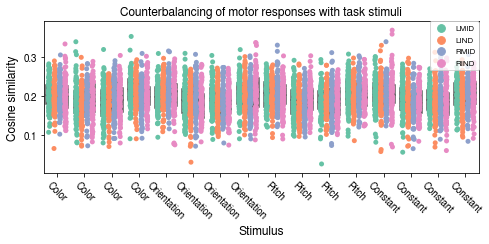

In [193]:
stimticks = []
stimticks.extend(np.repeat('Color',4))
stimticks.extend(np.repeat('Orientation',4))
stimticks.extend(np.repeat('Pitch',4))
stimticks.extend(np.repeat('Constant',4))
plt.figure(figsize=(7.,3.5))
plt.title('Counterbalancing of motor responses with task stimuli', fontsize=12)
ax = sns.boxplot(x="Stimulus",y='Cosine',hue='Response',data=df,whis=0,showfliers = False,palette="Set2")
sns.stripplot(x="Stimulus",y='Cosine',hue='Response',data=df,dodge=True,palette="Set2")
plt.xticks(np.arange(len(stimticks)), stimticks,rotation=-45,fontsize=10);
plt.yticks(fontsize=10)
plt.xlabel('Stimulus',fontsize=12)
plt.ylabel('Cosine similarity',fontsize=12)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-4:], ['LMID','LIND','RMID','RIND'], loc=1, borderaxespad=0., prop={'size': 8})
plt.tight_layout()
plt.savefig('CounterbalancingMotorResponseXStim.png',dpi=300)

#### Run t-tests for all stimuli

In [96]:
fs = []
ps = []
for stim in np.unique(df.Stimulus.values):
    tmpdf = df.loc[df.Stimulus==stim]
    tmplmid = tmpdf.Cosine[df.Response=='Response_LMID']
    tmplind = tmpdf.Cosine[df.Response=='Response_LIND']
    tmprmid = tmpdf.Cosine[df.Response=='Response_RMID']
    tmprind = tmpdf.Cosine[df.Response=='Response_RIND']
    f, p = stats.f_oneway(tmplmid.values,tmplind.values,tmprmid.values,tmprind.values)
    fs.append(f)
    ps.append(p)
qs = mc.fdrcorrection0(ps)[1]